In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt

In [2]:
def generate_dataset(num_samples):
    """
    Generate a dataset of images with a single pixel having a value of 255.
    """
    images = []
    labels = []
    for _ in range(num_samples):
        image = np.zeros((50, 50), dtype=np.uint8)
        x, y = np.random.randint(0, 50), np.random.randint(0, 50)
        image[x, y] = 255
        images.append(image)
        labels.append([x/50.0, y/50.0])
    return np.array(images), np.array(labels)


# Generate the dataset
num_samples = 10000
images, labels = generate_dataset(num_samples)

# Add channel dimension to images
images = images[..., np.newaxis]

In [3]:
def create_model():
    """
    Create a Convolutional Neural Network model for predicting pixel coordinates.
    
    """
    model = models.Sequential([
        layers.Input(shape=(50, 50, 1)),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(2, activation='sigmoid')  # Use sigmoid to ensure output is between 0 and 1
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    
    return model


In [4]:
model = create_model()

def lr_scheduler(epoch, lr): # lr_scheduler function reduces the learning rate after the 10th epoch, which can help with fine-tuning the model
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
# callbacks method for enabeling use of learning rate shedular and early stopping.
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(images, labels, epochs=10, validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 83s 316ms/step - loss: 0.0626 - mae: 0.0294 - val_loss: 0.0073 - val_mae: 0.0437
Epoch 2/10
250/250 [==============================] - 79s 317ms/step - loss: 0.0029 - mae: 0.0217 - val_loss: 0.0026 - val_mae: 0.0355
Epoch 3/10
250/250 [==============================] - 75s 300ms/step - loss: 0.0013 - mae: 0.0185 - val_loss: 0.0015 - val_mae: 0.0269
Epoch 4/10
250/250 [==============================] - 73s 291ms/step - loss: 0.0011 - mae: 0.0181 - val_loss: 0.0019 - val_mae: 0.0317
Epoch 5/10
250/250 [==============================] - 73s 293ms/step - loss: 9.8384e-04 - mae: 0.0167 - val_loss: 0.0021 - val_mae: 0.0347
Epoch 6/10
250/250 [==============================] - 76s 306ms/step - loss: 0.0010 - mae: 0.0169 - val_loss: 0.0014 - val_mae: 0.0254
Epoch 7/10
250/250 [==============================] - 77s 308ms/step - loss: 9.2944e-04 - mae: 0.0161 - val_loss: 0.0024 - val_mae: 0.0390
Epoch 8/10
250/250 [===========================

Here We are getting loss 0.000839, mae = 0.0151,  val_loss = 0.0019 so with these values we can say that out model is perfoming well.

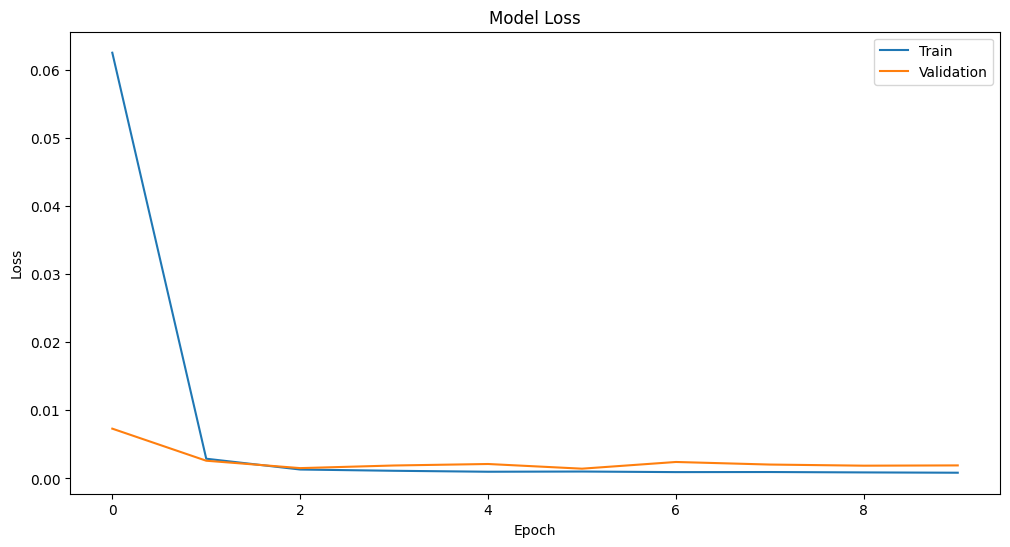

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [12]:
test_images, test_labels = generate_dataset(100)
test_images = test_images[..., np.newaxis]
predictions = model.predict(test_images)


4/4 [==============================] - 0s 61ms/step


Test MAE: 0.03


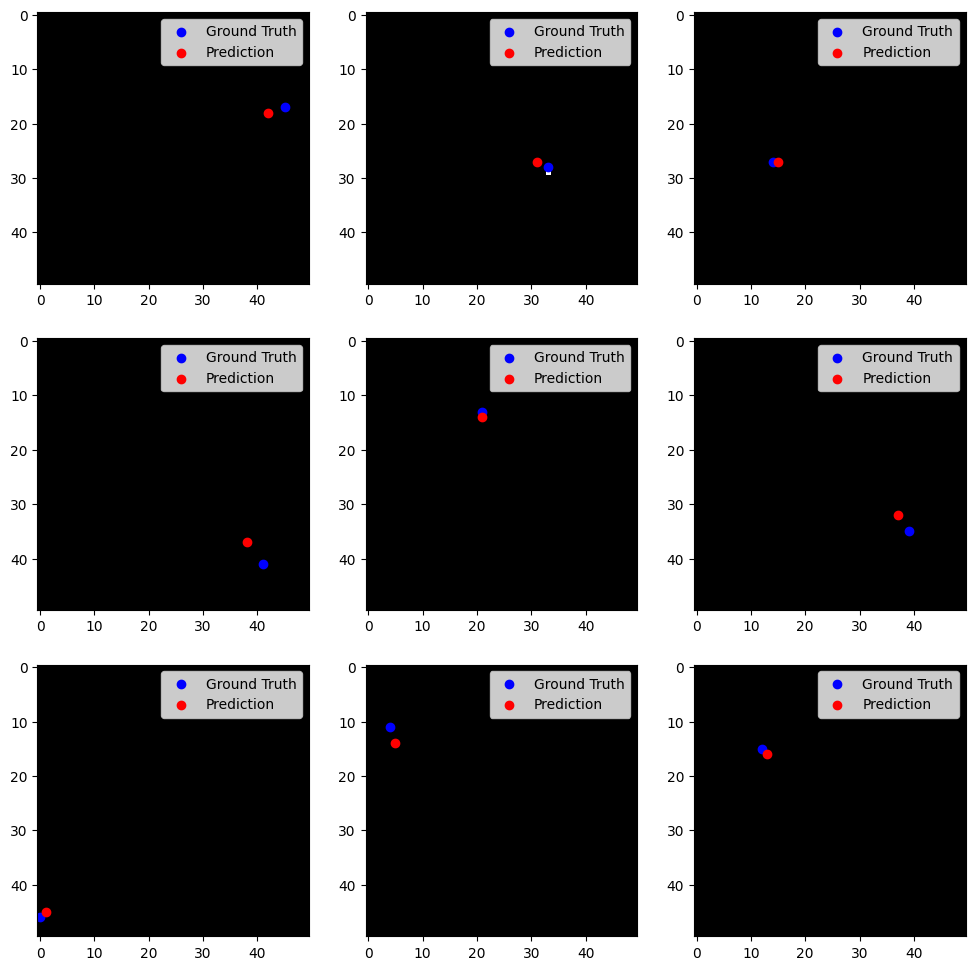

In [13]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Calculate MAE for the test set
test_mae = mean_absolute_error(test_labels, predictions)
print(f"Test MAE: {test_mae:.2f}")

# Plot a few examples with ground truth and predicted coordinates
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i].reshape(50, 50), cmap='gray')
    true_x, true_y = test_labels[i]
    pred_x, pred_y = predictions[i]
    true_x, true_y = int(true_x * 50), int(true_y * 50)
    pred_x, pred_y = int(pred_x * 50), int(pred_y * 50)
    plt.scatter(true_y, true_x, color='blue', label='Ground Truth')
    plt.scatter(pred_y, pred_x, color='red', label='Prediction')
    plt.legend()
plt.show()

Here we see how our model is performing by visualizing the actual and prediction co-ordinates.